### Importing Libraries 

In [1]:
from glob import glob
import cv2
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.utils import normalize
from keras.models import Sequential
from tensorflow.keras import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16

### connecting with kaggle dir 

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manu0589","key":"781270b7f9a8d0e147c626ae65786ce8"}'}

In [3]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

### Downloading Data 

In [7]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria #download dataset from kaggle

100% 672M/675M [00:04<00:00, 212MB/s]
100% 675M/675M [00:04<00:00, 162MB/s]


In [8]:
import os
zip_path = '/content/cell-images-for-detecting-malaria.zip'

In [9]:
from zipfile import ZipFile
with ZipFile(zip_path,'r') as zip:
  zip.extractall()
  print('Done')

Done


### image visualization 

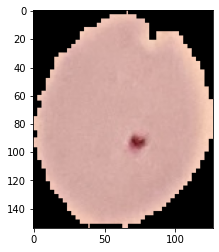

In [10]:
import matplotlib.pyplot as plt
im = plt.imread('/content/cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_180.png')
plt.imshow(im)
plt.show()

In [11]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!rm -rf '/content/cell_images/cell_images/'

### Creating Train and Test folders 

In [13]:
import splitfolders
splitfolders.ratio("/content/cell_images", output="output", seed=1337, ratio=(.8, .2)) # default values

Copying files: 27560 files [00:09, 2812.11 files/s]


### Using image Augmentation 

In [14]:
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.4,1.5],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,vertical_flip=True)

test_data = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_data.flow_from_directory(
        "/content/output/train", 
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        class_mode='binary')
validation_generator = test_data.flow_from_directory(
        "/content/output/val",
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


### initializing cnn model 

In [16]:
INPUT_SHAPE = (150, 150, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))  

In [17]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc'])

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

### Model training  

In [19]:
history = model.fit_generator(
     train_generator,
     steps_per_epoch=100,  # 2000 images = batch_size * steps
     epochs=15,
     validation_data=validation_generator,
     validation_steps=50,  # 1000 images = batch_size * steps
     verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/15
100/100 - 28s - loss: 0.7101 - acc: 0.5615 - val_loss: 0.6811 - val_acc: 0.5930 - 28s/epoch - 281ms/step
Epoch 2/15
100/100 - 17s - loss: 0.6827 - acc: 0.5590 - val_loss: 0.6902 - val_acc: 0.5830 - 17s/epoch - 169ms/step
Epoch 3/15
100/100 - 16s - loss: 0.6930 - acc: 0.5070 - val_loss: 0.6919 - val_acc: 0.5060 - 16s/epoch - 164ms/step
Epoch 4/15
100/100 - 15s - loss: 0.6926 - acc: 0.5210 - val_loss: 0.6890 - val_acc: 0.5160 - 15s/epoch - 148ms/step
Epoch 5/15
100/100 - 17s - loss: 0.6442 - acc: 0.6435 - val_loss: 0.6972 - val_acc: 0.9110 - 17s/epoch - 169ms/step
Epoch 6/15
100/100 - 15s - loss: 0.6599 - acc: 0.5620 - val_loss: 0.6889 - val_acc: 0.5180 - 15s/epoch - 153ms/step
Epoch 7/15
100/100 - 15s - loss: 0.6945 - acc: 0.5200 - val_loss: 0.6749 - val_acc: 0.5190 - 15s/epoch - 155ms/step
Epoch 8/15
100/100 - 15s - loss: 0.6238 - acc: 0.6475 - val_loss: 0.5372 - val_acc: 0.8280 - 15s/epoch - 154ms/step
Epoch 9/15
100/100 - 16s - loss: 0.5426 - acc: 0.7970 - val_loss: 0.4285

In [20]:
model.save('models/malaria_model_100epochs.h5')

### visualization of training and validation loss and accuracy 

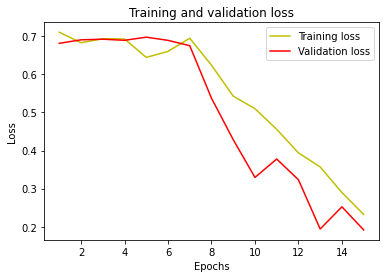

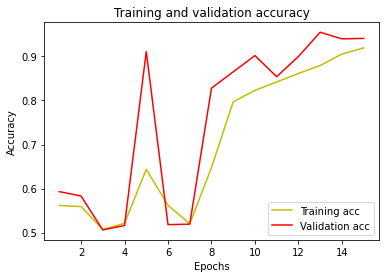

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Binary class classification Using Transfer Learning Model **Vgg16**

In [22]:
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.4,1.5],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,vertical_flip=True)

test_data = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator_vgg = train_data.flow_from_directory(
        "/content/output/train", 
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        class_mode='binary')
validation_generator_vgg = test_data.flow_from_directory(
        "/content/output/val",
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [32]:
tf.keras.backend.clear_session()

In [33]:
model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [34]:
for layer in model.layers:
    layer.trainable = False

In [35]:
x = layers.Flatten()(model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)
my_model = tf.keras.models.Model(model.input, x)
# Compile the model

# model summary
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
my_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [37]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('malaria_model_100epochs_vgg16.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [38]:
history = my_model.fit_generator(
     train_generator_vgg,
     steps_per_epoch=100,  # 2000 images = batch_size * steps
     epochs=15,
     validation_data=validation_generator_vgg,
     validation_steps=50,  # 1000 images = batch_size * steps
     verbose=2, callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.81900, saving model to malaria_model_100epochs_vgg16.h5
100/100 - 36s - loss: 1.0860 - accuracy: 0.6210 - val_loss: 0.5363 - val_accuracy: 0.8190 - 36s/epoch - 360ms/step
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.81900
100/100 - 35s - loss: 0.5703 - accuracy: 0.7125 - val_loss: 0.5151 - val_accuracy: 0.7340 - 35s/epoch - 346ms/step
Epoch 3/15

Epoch 3: val_accuracy improved from 0.81900 to 0.85200, saving model to malaria_model_100epochs_vgg16.h5
100/100 - 35s - loss: 0.5103 - accuracy: 0.7455 - val_loss: 0.4295 - val_accuracy: 0.8520 - 35s/epoch - 353ms/step
Epoch 4/15

Epoch 4: val_accuracy improved from 0.85200 to 0.86000, saving model to malaria_model_100epochs_vgg16.h5
100/100 - 36s - loss: 0.5294 - accuracy: 0.7440 - val_loss: 0.4121 - val_accuracy: 0.8600 - 36s/epoch - 361ms/step
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.86000
100/100 - 37s - loss: 0.4954 - accuracy: 0.7565 - val_loss: 0.4479

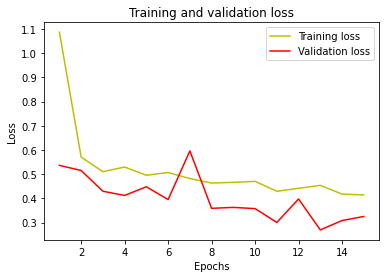

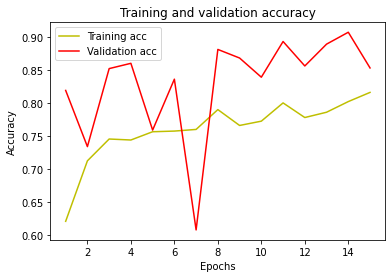

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()